In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Will use 5 different machine learning models to train the data and make prediciotn,here are the models will be used: k-nearest neighbors Decision Tree Classifier RandomForestClassifier LogisticRegression Super Vector Machine (svm)

# Import libraries:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Read data: 

In [12]:
data = pd.read_csv('/kaggle/input/titanic/train.csv')
test= pd.read_csv('/kaggle/input/titanic/test.csv')

# Some investigation on data :

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.shape

(891, 12)

### Look for missing values in Train data:

In [5]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Look for missing values in Test data

In [7]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Looking for Percentage of missing value in both data

In [8]:
precent_null_train = data.isnull().sum().sum()/np.product(data.shape)*100
precent_null_test = test.isnull().sum().sum()/np.product(test.shape)*100

print('Percetnage of null values in train data: ',precent_null_train)
print('-'*60)
print('Percetnage of null values in test data: ',precent_null_test)

Percetnage of null values in train data:  8.099513655069211
------------------------------------------------------------
Percetnage of null values in test data:  9.00391474554154


In [9]:
precent_null_train_cabin= data['Cabin'].isnull().sum()/data.shape[0]*100
precent_null_test_cabin= test['Cabin'].isnull().sum()/test.shape[0]*100
print('Percetnage of null values in column Cabin in train data: ',precent_null_train_cabin)
print('-'*60)
print('Percetnage of null values in column Cabin in test data: ',precent_null_test_cabin)

Percetnage of null values in column Cabin in train data:  77.10437710437711
------------------------------------------------------------
Percetnage of null values in column Cabin in test data:  78.22966507177034


As we can see here 77% of data in Cabin column are missing, so drop this column since it doesnt provide usefull information.

In [13]:
#drop cabin column
data.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

In [14]:
#drop ticket column
data.drop('Ticket',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)

### Plots:

<AxesSubplot:xlabel='Survived', ylabel='count'>

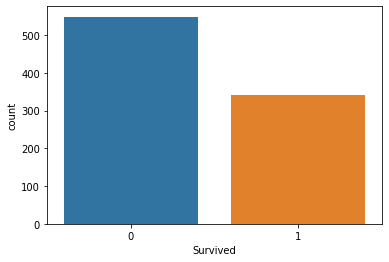

In [15]:
sns.countplot(x='Survived',data=data)

<AxesSubplot:xlabel='Survived', ylabel='count'>

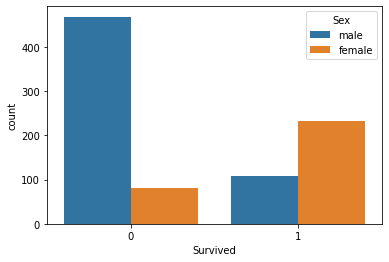

In [16]:
sns.countplot(x='Survived',hue='Sex',data=data)


<AxesSubplot:xlabel='Survived', ylabel='count'>

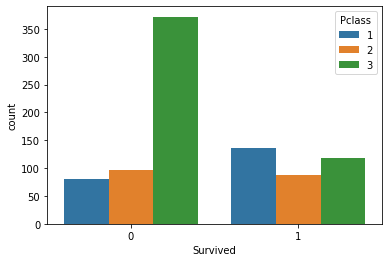

In [17]:
sns.countplot(x='Survived',hue='Pclass',data=data)


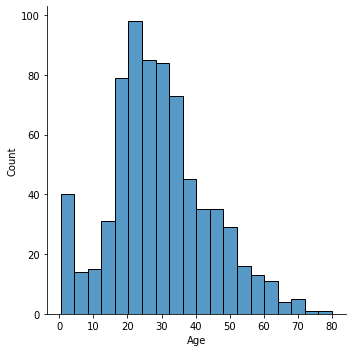

In [18]:
sns.displot(data['Age'].dropna())

<AxesSubplot:xlabel='SibSp', ylabel='count'>

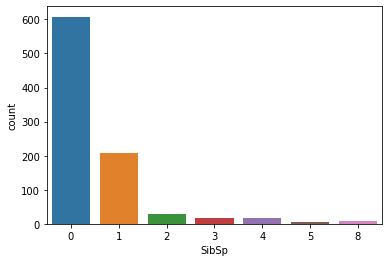

In [19]:
sns.countplot(x='SibSp', data=data)

<AxesSubplot:>

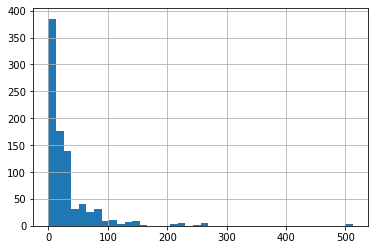

In [20]:
data['Fare'].hist(bins=40)

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

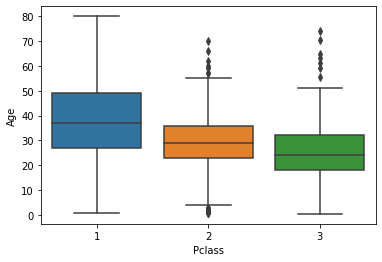

In [22]:
sns.boxplot(x='Pclass',y='Age',data=data)

In [34]:
#divided age to for  categgory kid, , tennger, adult and adged to look for wthic category is most survived
data['life_stage']=0

for i in data['Age'].index:
    if data['Age'].loc[i] in list(range(1,11)):
        data['life_stage'].loc[i]= 'Kid'
        
    if data['Age'].loc[i] in list(range(11,21)):
        data['life_stage'].loc[i]= 'Tennger'
        
    if data['Age'].loc[i] in list(range(21,51)):
        data['life_stage'].loc[i]= 'adult'
    
    if data['Age'].loc[i] in list(range(51,120)):
        data['life_stage'].loc[i]= 'adged'

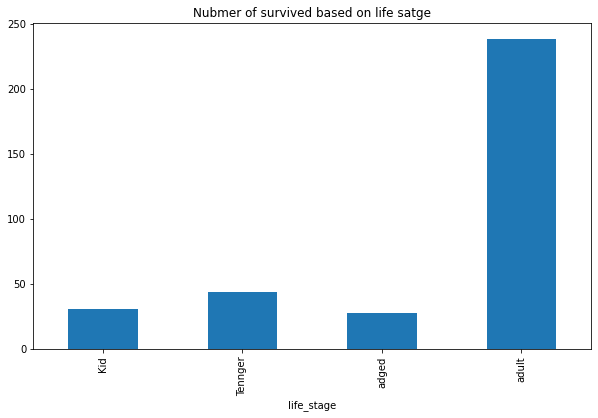

In [35]:
data.groupby('life_stage').sum()['Survived'].plot(kind='bar',figsize=(10,6))
plt.title('Nubmer of survived based on life satge')
plt.show();

Here we added a new column represnt life stage based on adges.

### Handling Missing values:

In [23]:
#Impute Age column with "Mean" of each class

def impute_age(cols):
    Age=cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Age):
        if Pclass==1:
            return 37
        elif Pclass==2:
            return 29
        else:
            return 24
    else:
        return Age

In [24]:
data['Age']=data[['Age','Pclass']].apply(impute_age,axis=1)
test['Age']=test[['Age','Pclass']].apply(impute_age,axis=1)

In [25]:
#All 177 null values in Age column disappeared
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [27]:
#Filling missing value in Embarked column with previous value 
data.Embarked.fillna(method='bfill',inplace=True)

#Filling missing value in Fare column with previous value 
test.Fare.fillna(method='bfill',inplace=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         418 non-null    float64
 8   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


In [30]:
#looking for duplicated rows in both data
data.duplicated().sum(),test.duplicated().sum()

(0, 0)

Fortunately no duplicated values in both datasets (Train and Test).

In [31]:
#quick statistics describtion on the data
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.066409,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.244532,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In age column min age is 0.42, so we need to normlize age data.

In [32]:
#Looking for all value under 1, multiplay *100 and covert all column to int
age_index = data[data['Age']<1].index
data.Age.loc[age_index]= data.Age.loc[age_index]*100
data['Age'] = data['Age'] .astype(int)

In [33]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.630752,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.645492,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,92.000000,8.000000,6.000000,512.329200


Looking for unqiue values in categorical columns:


In [38]:
data[['Survived','Pclass','Sex','SibSp','Parch','Embarked','life_stage']].nunique()

Survived      2
Pclass        3
Sex           2
SibSp         7
Parch         7
Embarked      3
life_stage    4
dtype: int64

In [37]:
#This function is used to encode categorical column with ONE HOT ENCODING APPROCHE
def oh_encoding(X):
    # Select categorical columns 
    categorical_cols = X.select_dtypes(include='object')

    # Select numerical columns
    numerical_cols = X.select_dtypes(exclude='object')


    # Apply one-hot encoder to each column with categorical data
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_X_full = pd.DataFrame(OH_encoder.fit_transform(categorical_cols))

    # One-hot encoding removed index; put it back
    OH_X_full.index = categorical_cols.index

    # Add one-hot encoded columns to numerical features
    OH_X = pd.concat([numerical_cols, OH_X_full], axis=1)
    return OH_X

In [41]:
#select target column 
y = data['Survived']

#select indempendant columns
X = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

#get indempendant column for train data set
X_full = data[X].copy()

#get indempendant column for test data set
X_test = test[X].copy()



#Use train test split approche
X_train, X_valid, y_train, y_valid = train_test_split(oh_encoding(X_full), y,train_size=0.8, test_size=0.2, random_state=0)

# Modelling

## K-Nearest Neighbors

K-Nearest Neighbors is a supervised learning algorithm. Where the data is 'trained' with data points corresponding to their classification. To predict the class of a given data point, it takes into account the classes of the 'K' nearest data points and chooses the class in which the majority of the 'K' nearest data points belong to as the predicted class.

In [42]:
#function to find the best result of accuracy score for KNeighborsClassifier
def get_as_dtr(n_neighbors, train_X, val_X, train_y, val_y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    ae = accuracy_score(val_y, preds_val)
    return(ae) 

In [43]:
# loop to find the ideal n_neighbors size 
scores = {k_size: get_as_dtr(k_size, X_train, X_valid, y_train, y_valid) for k_size in range(1,10)}
best_k_size = max(scores, key=scores.get)

ae_decision = scores[best_k_size]
print('Best result at max n_neighbors : ',best_k_size)
print('accuracy score for KNeighborsClassifier: ',ae_decision)

Best result at max n_neighbors :  7
accuracy score for KNeighborsClassifier:  0.7486033519553073


In [44]:
#build knn model for best score
kn_model = KNeighborsClassifier(n_neighbors=best_k_size)
kn_model.fit(X_train, y_train)
preds_kn = kn_model.predict(X_valid)

#### First method to plot confusion matrix:

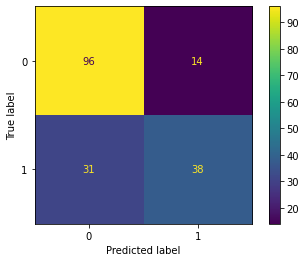

In [45]:
plot_confusion_matrix(kn_model, X_valid, y_valid)

#### Second method to plot confusion matrix:

In [46]:
kn_model.classes_

array([0, 1])

In [47]:
#Actual = y_valid
#Predicted = preds_kn

# Compute confusion matrix
cnf_matrix_kn = confusion_matrix(y_valid,preds_kn, labels=kn_model.classes_)
print ("Confusion Matrix:\n",cnf_matrix_kn)


Confusion Matrix:
 [[96 14]
 [31 38]]


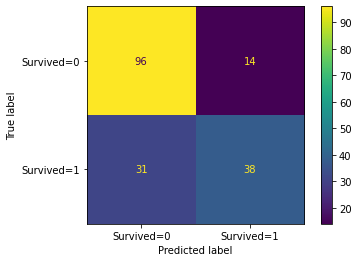

In [48]:
# Plot non-normalized confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_kn, display_labels=['Survived=0','Survived=1'])
cm_display.plot()

# DecisionTreeClassifier

In [49]:
dtc_model = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
dtc_model.fit(X_train, y_train)
prediction_dtc = dtc_model.predict(X_valid)

print('accuracy score for DecisionTreeClassifier: ',accuracy_score(y_valid,prediction_dtc))

accuracy score for DecisionTreeClassifier:  0.8044692737430168


In [50]:
#Actual = y_valid
#Predicted = prediction_dtc

# Compute confusion matrix
cnf_matrix_dtc = confusion_matrix(y_valid,prediction_dtc, labels=dtc_model.classes_)
print ("Confusion Matrix:\n",cnf_matrix_dtc)

Confusion Matrix:
 [[94 16]
 [19 50]]


<Figure size 720x576 with 0 Axes>

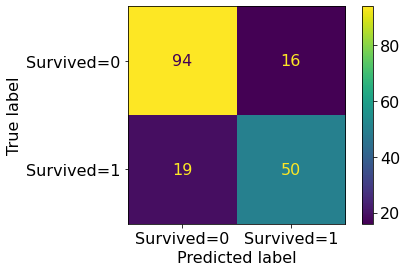

In [51]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = '16'
cm_display = ConfusionMatrixDisplay(cnf_matrix_dtc, display_labels=['Survived=0','Survived=1'])
cm_display.plot()

# Random Forest Classifier

In [52]:
#function to find resturn the result of accuracy score for KNeighborsClassifier
def get_rfc(n_estimators, train_X, val_X, train_y, val_y):
    model = model = RandomForestClassifier(n_estimators=n_estimators, max_depth=5, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    ae = accuracy_score(val_y, preds_val)
    return(ae) 

In [53]:
# loop to find the ideal n_neighbors size 
scores = {n_size: get_rfc(n_size, X_train, X_valid, y_train, y_valid) for n_size in range(1,100)}
best_n_size = max(scores, key=scores.get)

best_score = scores[best_n_size]
print('Best result at max n_neighbors : ',best_n_size)
print('accuracy score for Random Forest Classifier: ',best_score)

Best result at max n_neighbors :  11
accuracy score for Random Forest Classifier:  0.8379888268156425


In [54]:
#Build RandomForestClassifier for best scoore at best n_estimators
model_rfc = RandomForestClassifier(n_estimators=best_n_size, max_depth=5, random_state=1)
model_rfc.fit(X_train, y_train)
preds_rfc = model_rfc.predict(X_valid)

In [55]:
#Actual = y_valid
#Predicted = preds_rfc

# Compute confusion matrix
cnf_matrix_rfc = confusion_matrix(y_valid,preds_rfc, labels=model_rfc.classes_)
print ("Confusion Matrix:\n",cnf_matrix_rfc)

Confusion Matrix:
 [[104   6]
 [ 23  46]]


<Figure size 720x576 with 0 Axes>

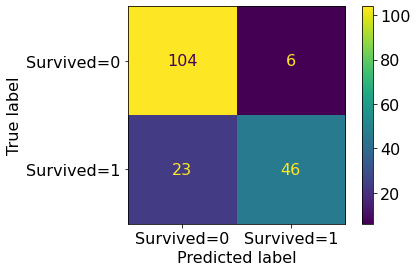

In [56]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = '16'
cm_display = ConfusionMatrixDisplay(cnf_matrix_rfc, display_labels=['Survived=0','Survived=1'])
cm_display.plot()

## Logistic Regression

In [58]:
LR_model = LogisticRegression(C=0.01, solver='liblinear')
LR_model.fit(X_train,y_train) 
prediction_lr = LR_model.predict(X_valid)
print('accuracy score for Logistic Regression',accuracy_score(y_valid,prediction_lr))

accuracy score for Logistic Regression 0.7821229050279329


In [59]:
#Actual = y_valid
#Predicted = prediction_lr

# Compute confusion matrix
cnf_matrix_lr = confusion_matrix(y_valid,prediction_lr, labels=LR_model.classes_)
print ("Confusion Matrix:\n",cnf_matrix_lr)

Confusion Matrix:
 [[106   4]
 [ 35  34]]


<Figure size 720x576 with 0 Axes>

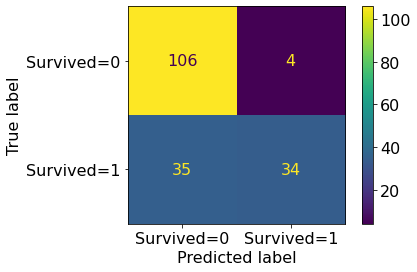

In [60]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = '16'
cm_display = ConfusionMatrixDisplay(cnf_matrix_lr, display_labels=['Survived=0','Survived=1'])
cm_display.plot()

## Support Vector Machines

In [61]:
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
prediction_svm = svm_model.predict(X_valid)
print('accuracy score for Support Vector Machines',accuracy_score(y_valid,prediction_svm))

accuracy score for Support Vector Machines 0.7150837988826816


In [62]:
#Actual = y_valid
#Predicted = prediction_svm

# Compute confusion matrix
cnf_matrix_svm = confusion_matrix(y_valid,prediction_svm, labels=svm_model.classes_)
print ("Confusion Matrix:\n",cnf_matrix_svm)

Confusion Matrix:
 [[104   6]
 [ 45  24]]


<Figure size 720x576 with 0 Axes>

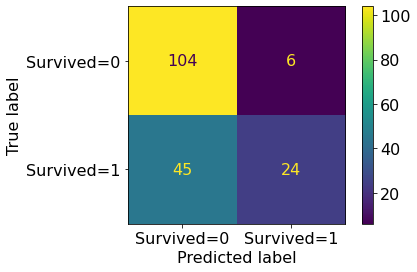

In [63]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = '16'
cm_display = ConfusionMatrixDisplay(cnf_matrix_svm, display_labels=['Survived=0','Survived=1'])
cm_display.plot()

# Predictions Scores For All Five Models

As we can see all models give similar Acuuracy score, so lets use some different appraoches to look for prediction score.

In [65]:
accu_preds = [preds_kn,prediction_dtc,preds_rfc,prediction_lr,prediction_svm]

accu_df = pd.DataFrame(index=['K-Nearest Neighbors',
                              'DecisionTreeClassifier',
                              'Random Forest Classifier',
                              'Logistic Regression',
                              'Support Vector Machines'])

accu_df['Acuuracy_score']=[accuracy_score(y_valid,i) for i in accu_preds]
accu_df['F1_score']=[f1_score(y_valid, i, average='weighted')  for i in accu_preds]
accu_df['Jaccard_score']=[jaccard_score(y_valid, i,pos_label=0)  for i in accu_preds]
accu_df

,Acuuracy_score,F1_score,Jaccard_score
K-Nearest Neighbors,0.748603,0.739960,0.680851
DecisionTreeClassifier,0.804469,0.803612,0.728682
Random Forest Classifier,0.837989,0.832418,0.781955
Logistic Regression,0.782123,0.764016,0.731034
Support Vector Machines,0.715084,0.680415,0.670968


Regarding to above table, almost all values are similar, so lets use Random Forest Classifier to submit the competition :)

In [66]:
model= RandomForestClassifier(n_estimators=best_n_size, max_depth=5, random_state=1)

# Preprocessing of training data, fit model 
model.fit(oh_encoding(X_full), y)

# Preprocessing of validation data, get predictions
predictions = model.predict(oh_encoding(X_test))

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
